# Fine‑Tuning guide (Optuna + pruning/quantization)

This notebook is a **hands‑on guide** for running hyperparameter fine‑tuning with Optuna, integrating pruning and quantization.

It covers:
1. Experiment setup & reproducibility
2. Search space definitions
3. Optuna sampler selection
4. Objective functions
5. Running studies
6. Visualising results


## Environment & installs

Uncomment and run if you need to install dependencies in this environment

In [ ]:
!pip install optuna
!pip install mlflow==2.9.0

## 1. Finetuning configuration

The most important part of the module is a `finetuning.yaml` - config, where you indicate all parameters used during the trials. 

Let's break down every part of the config file together:

# finetuning.yaml example

```yaml
pruning_parameters:
  disable_pruning_for_layers: []
  pruning_method: pdp

quantization_parameters:
  default_integer_bits: 0.0
  default_fractional_bits: 7.0
  enable_quantization: true
  hgq_gamma: 0.0003
  hgq_heterogeneous: true
  layer_specific: []
  use_high_granularity_quantization: false
  use_real_tanh: false
  use_symmetric_quantization: false

training_parameters:
  batch_size: 128
  optimizer: sgd
  plot_frequency: 100
  label_smoothing: 0
  model: "resnet18"
  dataset: "cifar10"
  l2_decay: 0.001
  momentum: 0.9
  lr_schedule: "cosine"
  milestones: [30, 80]
  gamma: 0.1
  cosine_tmax: 200
  lr: 0.001
  prune_ratio: 10
  default_integer_bits: 0
  epochs: 2
  fine_tuning_epochs: 2
  pretraining_epochs: 0
  pruning_first: false
  rewind: "post-ticket-search"
  rounds: 2
  save_weights_epoch: 2

finetuning_parameters:
  experiment_name: "resnet_18_experiment"
  num_trials: 10
  sampler:
    type: TPESampler
    params: {}
  hyperparameter_search:
    numerical:
      learning_rate: [1e-5, 1e-3, 0.2]   # [low, high, step]
      batch_size: [16, 128, 32]          
      default_integer_bits: [0, 8, 1]
    categorical:
      lr_schedule: ["cosine", "multistep"]
```

## It has four separate sections: training, pruning, quantization and finetuning parameters.

## 1) Pruning parameters:

Provide **one** of the schemas below under `pruning_parameters`,  the `pruning_method` value selects the correct model and other values are validated by Pydantic model. If no values specified, the default ones will be used.

## Common Fields (used by all methods)

| Field | Type | Default | Description |
|---|---|---:|---|
| `disable_pruning_for_layers` | `List[str]` | `[]` | Layer names to exclude from pruning. |
| `enable_pruning` | `bool` | `true` | Master on/off switch. |
| `threshold_decay` | `float` | `0.0` | Optional decay term.  |

! Layer names should match your framework’s naming (e.g., Keras `layer.name`).

## Method Overview

| Method | Model |
|---|---|
| `cs` | **CSPruningModel** |
| `dst` | **DSTPruningModel** |
| `pdp` | **PDPPruningModel** | 
| `wanda` | **WandaPruningModel** |
| `autosparse` | **AutoSparsePruningModel** | 
| `activation_pruning` | **ActivationPruningModel** | 
| `mdmm` | **MDMMPruningModel** |


## CSPruningModel 
 `pruning_method: "cs"`

| Field | Type | Default | Description |
|---|---|---:|---|
| `pruning_method` | `str` | — | Selects this schema. |
| `final_temp` | `int` | `200` | Target temperature at end of schedule. |
| `threshold_init` | `int` | `0` | Initial sparsification threshold. |

**YAML example:**
```yaml
pruning_parameters:
  pruning_method: cs
  final_temp: 200
  threshold_init: 0
  disable_pruning_for_layers: []
  enable_pruning: true
```

## DSTPruningModel
`pruning_method: "dst"`

| Field | Type | Default | Description |
|---|---|---:|---|
| `pruning_method` | `str` | — | Selects this schema. |
| `alpha` | `float` | `5.0e-06` | Mask dynamics update coefficient. |
| `max_pruning_pct` | `float` | `0.99` | Upper bound on total pruning ratio. |
| `threshold_init` | `float` | `0.0` | Initial threshold value. |
| `threshold_type` | `str` | `"channelwise"` | Thresholding granularity. |

**YAML example:**
```yaml
pruning_parameters:
  pruning_method: dst
  alpha: 5.0e-06
  max_pruning_pct: 0.99
  threshold_init: 0.0
  threshold_type: channelwise
```

## PDPPruningModel
`pruning_method: "pdp"`

| Field | Type | Default | Description |
|---|---|---:|---|
| `pruning_method` | `str` | — | Selects this schema. |
| `epsilon` | `float` | `0.015` | Smoothing/regularization factor for gating. |
| `sparsity` | `float` | `0.8` | Target sparsity level (0–1). |
| `temperature` | `float` | `1.0e-05` | Annealing temperature. |
| `structured_pruning` | `bool` | `false` | Enable structured pruning. |

**YAML example:**
```yaml
pruning_parameters:
  pruning_method: pdp
  epsilon: 0.015
  sparsity: 0.8
  temperature: 1.0e-05
  structured_pruning: false
```

## WandaPruningModel
 `pruning_method: "wanda"`

| Field | Type | Default | Description |
|---|---|---:|---|
| `pruning_method` | `str` | — | Selects this schema. |
| `M` | `Optional[int]` | `null` | Optional grouping constant. |
| `N` | `Optional[int]` | `null` | Optional grouping constant. |
| `sparsity` | `float` | `0.9` | Target sparsity level (0–1). |
| `t_delta` | `int` | `100` | Window/steps for stats collection. |
| `t_start_collecting_batch` | `int` | `100` | Warm-up steps before collecting stats. |
| `calculate_pruning_budget` | `bool` | `true` | Auto-compute budget from data. |

**YAML example:**
```yaml
pruning_parameters:
  pruning_method: wanda
  sparsity: 0.9
  M: null
  N: null
  t_delta: 100
  t_start_collecting_batch: 100
  calculate_pruning_budget: true
```

## AutoSparsePruningModel
`pruning_method: "autosparse"`

| Field | Type | Default | Description |
|---|---|---:|---|
| `pruning_method` | `str` | — | Selects this schema. |
| `alpha` | `float` | `0.5` | Weight/penalty coefficient. |
| `alpha_reset_epoch` | `int` | `90` | Epoch to reset/tune `alpha`. |
| `autotune_epochs` | `int` | `10` | Tuning window length. |
| `backward_sparsity` | `bool` | `false` | Apply sparsity in backward path if supported. |
| `threshold_init` | `float` | `-5.0` | Initial threshold (often logit-space). |
| `threshold_type` | `str` | `"channelwise"` | Thresholding granularity. |

**YAML example:**
```yaml
pruning_parameters:
  pruning_method: autosparse
  alpha: 0.5
  alpha_reset_epoch: 90
  autotune_epochs: 10
  backward_sparsity: false
  threshold_init: -5.0
  threshold_type: channelwise
```

## ActivationPruningModel
`pruning_method: "activation_pruning"`

| Field | Type | Default | Description |
|---|---|---:|---|
| `pruning_method` | `str` | — | Selects this schema. |
| `threshold` | `float` | `0.3` | Activation magnitude cutoff. |
| `t_delta` | `int` | `50` | Steps used to aggregate stats. |
| `t_start_collecting_batch` | `int` | `50` | Steps to skip before collecting. |

**YAML example:**
```yaml
pruning_parameters:
  pruning_method: activation_pruning
  threshold: 0.3
  t_delta: 50
  t_start_collecting_batch: 50
```

## MDMMPruningModel
`pruning_method: "mdmm"`

| Field | Type | Default | Description |
|---|---|---:|---|
| `pruning_method` | `str` | — | Selects this schema. |
| `constraint_type` | `ConstraintType` | `"Equality"` | Constraint form: equality / ≤ / ≥. |
| `target_value` | `float` | `0.0` | Target for the chosen metric. |
| `metric_type` | `MetricType` | `"UnstructuredSparsity"` | Which metric is constrained. |
| `target_sparsity` | `float` | `0.9` | Target sparsity when constraining sparsity. |
| `rf` | `int` | `1` | Regularization factor / frequency parameter. |
| `epsilon` | `float` | `1.0e-03` | Feasibility tolerance. |
| `scale` | `float` | `10.0` | Penalty scaling for constraint violation. |
| `damping` | `float` | `1.0` | Damping term for stability. |
| `use_grad` | `bool` | `false` | Use gradient information in updates. |
| `l0_mode` | `"coarse" \| "smooth"` | `"coarse"` | L0 approximation mode. |
| `scale_mode` | `"mean" \| "sum"` | `"mean"` | Aggregation mode for penalties. |

**YAML example:**
```yaml
pruning_parameters:
  pruning_method: mdmm
  constraint_type: Equality          # or LessThanOrEqual / GreaterThanOrEqual
  metric_type: UnstructuredSparsity  # or StructuredSparsity
  target_sparsity: 0.9
  epsilon: 0.001
  scale: 10.0
  damping: 1.0
  use_grad: false
  l0_mode: coarse
  scale_mode: mean
```

## 2) Quantization parameters:

| Field | Type | Default | Description |
|---|---|---:|---|
| `default_integer_bits` | `float` | `0.0` | Global integer bits for fixed‑point quantization. |
| `default_fractional_bits` | `float` | `7.0` | Global fractional bits for fixed‑point quantization. |
| `enable_quantization` | `bool` | `true` | Enable/disable quantization. |
| `hgq_gamma` | `float` | `0.0003` | HGQ regularization coefficient. |
| `hgq_heterogeneous` | `bool` | `true` | Allow heterogeneous bit‑widths. |
| `layer_specific` | `List` | `[]` | Optional per‑layer overrides. |
| `use_high_granularity_quantization` | `bool` | `false` | Enable high‑granularity quantization policy. |
| `use_real_tanh` | `bool` | `false` | Use a non‑approximate `tanh` operator. |
| `use_symmetric_quantization` | `bool` | `false` | Use symmetric quantization (zero‑point = 0). |
| `use_relu_multiplier` | `bool` | `true` | Apply ReLU multiplier optimization. |

**YAML example:**
```yaml
quantization_parameters:
  default_integer_bits: 0.0
  default_fractional_bits: 7.0
  enable_quantization: true
  hgq_gamma: 0.0003
  hgq_heterogeneous: true
  use_high_granularity_quantization: false
  use_real_tanh: false
  use_symmetric_quantization: false
  use_relu_multiplier: true
  layer_specific:
    - layer: "conv1"
      weight: { integer_bits: 0.0, fractional_bits: 7.0 }
      bias:   { integer_bits: 0.0, fractional_bits: 7.0 }
      relu:   { integer_bits: 0.0, fractional_bits: 7.0 }


## 3) Training parameters:

| Field | Type | Default | Description |
|---|---|---:|---|
| `epochs` | `int` | `200` | Total number of training epochs. |
| `fine_tuning_epochs` | `int` | `0` | Additional epochs for fine‑tuning. |
| `pretraining_epochs` | `int` | `50` | Pretraining/warmp‑up epochs. |
| `pruning_first` | `bool` | `false` | Apply pruning before main training loop. |
| `rewind` | `str` | `"never"` | Weight rewinding policy. |
| `rounds` | `int` | `1` | Number of training rounds/cycles. |
| `save_weights_epoch` | `int` | `-1` | Save checkpoint at this epoch (`-1` disables). |
| `batch_size` | `int` | `128` | Training batch size. |
| `optimizer` | `str` | `"sgd"` | Optimizer selection. |
| `plot_frequency` | `int` | `100` | Steps between progress plots. |
| `label_smoothing` | `float` | `0.0` | Label smoothing factor. |
| `model` | `str` | `"resnet18"` | Model architecture name. |
| `dataset` | `str` | `"cifar10"` | Dataset identifier. |
| `l2_decay` | `float` | `0.001` | L2 weight decay. |
| `momentum` | `float` | `0.9` | Momentum for SGD‑like optimizers. |
| `lr_schedule` | `Literal["cosine","step","none"]` | `"cosine"` | LR schedule policy. |
| `cosine_tmax` | `int` | `200` | Period (`T_max`) for cosine schedule. |
| `lr` | `float` | `0.001` | Learning rate. |
| `prune_ratio` | `float` | `10.0` | Method‑specific pruning ratio meaning. |
| `default_integer_bits` | `int` | `0` | Pass quant bits to training. |

**YAML example:**
```yaml
training_parameters:
  epochs: 200
  fine_tuning_epochs: 0
  pretraining_epochs: 50
  pruning_first: false
  rewind: "never"
  rounds: 1
  save_weights_epoch: -1
  batch_size: 128
  optimizer: "sgd"
  plot_frequency: 100
  label_smoothing: 0.0
  model: "resnet18"
  dataset: "cifar10"
  l2_decay: 0.001
  momentum: 0.9
  lr_schedule: "cosine"
  cosine_tmax: 200
  lr: 0.001
  prune_ratio: 10.0
  default_integer_bits: 0
```

## 4) Finetuning Parameters:


| Field | Type | Default | Description |
|---|---|---:|---|
| `experiment_name` | `str` | `"experiment_1"` | Name of the study. |
| `sampler` | `str` | `GridSampler` | Sampler selection for the search space. |
| `num_trials` | `int` | `0` | Number of trials. |
| `hyperparameter_search` | `HyperparameterSearch` | `{}` | Ranges for non‑grid samplers. |

**YAML example: Grid sampler**
```yaml
finetuning_parameters:
  experiment_name: "experiment_1"
  num_trials: 0
  sampler:
    type: "GridSampler"
    params:
      search_space:
        lr: [1e-5, 1e-4, 1e-3]
        batch_size: [32, 64, 128]
        lr_schedule: ["cosine", "step"]
```

### Samplers

| Field | Type | Default | Description |
|---|---|---:|---|
| `type` | `str` | `"TPESampler"` | Sampler class name (e.g., `TPESampler`, `GridSampler`). |
| `params` | `Dict[str, Any]` | `{}` | Sampler‑specific kwargs (e.g., `seed`, `search_space` for GridSampler). |

### HyperparameterSearch

| Field | Type | Default | Description |
|---|---|---:|---|
| `numerical` | `Dict[str, List[Union[int,float]]]` | `{}` | Numeric ranges, `[low, high, step]`. |
| `categorical` | `Optional[Dict[str, List[str]]]` | `{}` | Categorical choices. |



**YAML example: TPE with search ranges**
```yaml
finetuning_parameters:
  experiment_name: "experiment_1"
  num_trials: 30
  sampler:
    type: "TPESampler"
    params:
      seed: 42
  hyperparameter_search:
    numerical:
      lr: [1e-5, 1e-3, 0.2]   # [low, high, step]
      batch_size: [16, 128, 16]
    categorical:
      lr_schedule: ["cosine", "multistep"]
```

### After the config file is updated, we can run studies. 

In [ ]:
# Start a server if you want to use it locally
!mlflow server  --host 0.0.0.0 --port 5000

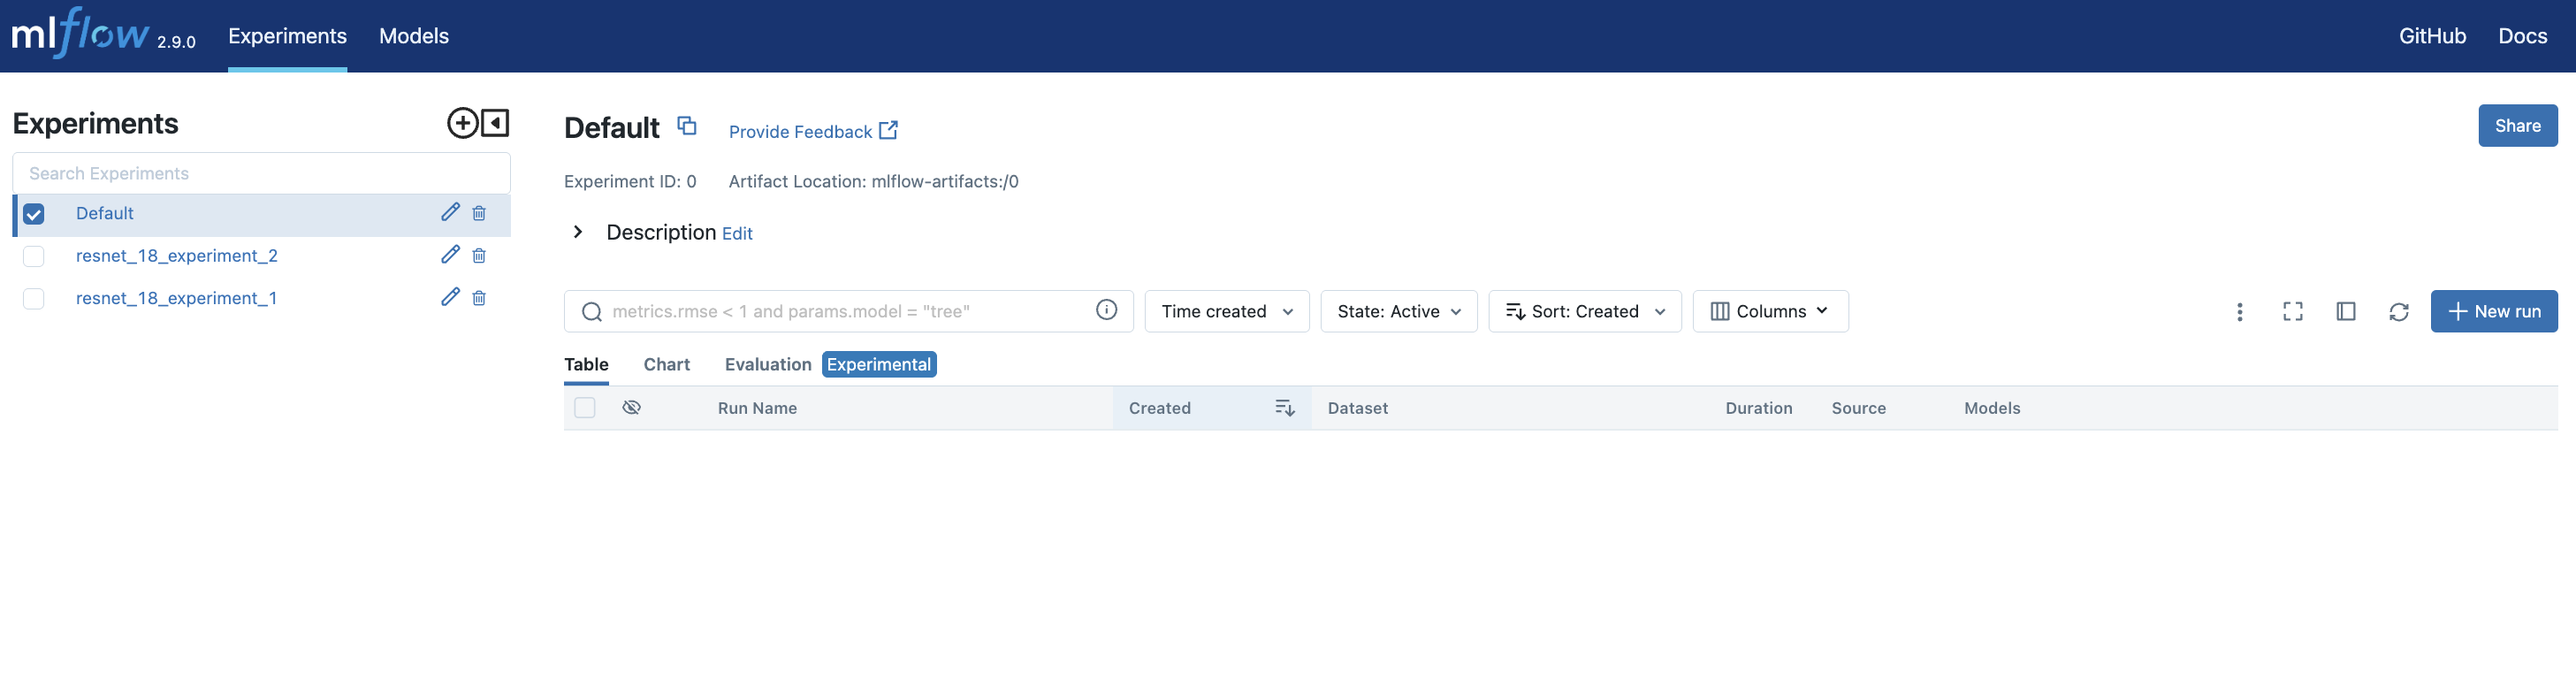

In [ ]:
# Define functions for model training, validation and accuracy calculation
def train_resnet(model, trainloader, device, loss_func, writer, epoch, optimizer, scheduler, *args, **kwargs):
    """Train ResNets for 1 epoch"""
    for data in tqdm.tqdm(trainloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        losses = get_model_losses(model, torch.tensor(0.0).to(device))
        loss += losses
        loss.backward()
        optimizer.step()
        epoch += 1
        if scheduler is not None:
            scheduler.step()
    if writer is not None:
        writer.add_scalar("train_output_loss", loss.item(), epoch)
        writer.add_scalar("train_sparse_loss", losses, epoch)

def validate_resnet(model, testloader, device, loss_func, epoch, writer, *args, **kwargs):
    """Validation loop for ResNets"""
    correct = 0
    total = 0
    model.eval()

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            if loss_func is not None:
                loss = loss_func(outputs, labels)
                losses = get_model_losses(model, torch.tensor(0.0).to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        ratio = get_layer_keep_ratio(model)
        if writer is not None:
            writer.add_scalar("validation_output_loss", loss.item(), epoch)
            writer.add_scalar("validation_sparse_loss", losses, epoch)
            writer.add_scalar("validation_acc", correct / total, epoch)
            writer.add_scalar("validation_remaining_weights", ratio, epoch)

def calculate_accuracy(model, testloader, device, loss_func, *args, **kwargs):
    """Validation loop for ResNets with accuracy return"""
    correct = 0
    total = 0
    loss = None
    losses = None
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            if loss_func is not None:
                loss = loss_func(outputs, labels)
                losses = get_model_losses(model, torch.tensor(0.0).to(device))

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total if total > 0 else 0.0
    ratio = get_layer_keep_ratio(model)

    return accuracy

In [ ]:
# Define scheduler and optimizer functions
def get_scheduler(optimizer, config):
    if config.training_parameters.lr_schedule is None:
        return None
    elif config.training_parameters.lr_schedule == "cosine":
        return CosineAnnealingLR(optimizer, config.training_parameters.cosine_tmax)
    elif config.training_parameters.lr_schedule == "multistep":
        return MultiStepLR(optimizer, config.training_parameters.milestones, gamma=config.training_parameters.gamma)
    return None

def get_optimizer(config, model):
    if config.training_parameters.optimizer == "sgd":
        # CS already has L1-regularization for threshold parameters
        threshold_decay = (
            0 if (config.pruning_parameters.pruning_method == "cs" or config.pruning_parameters.pruning_method == "mdmm") else config.pruning_parameters.threshold_decay
        )

        parameters = list(model.named_parameters())
        threshold_params = [v for n, v in parameters if "threshold" in n and v.requires_grad]
        rest_params = [v for n, v in parameters if "threshold" not in n and v.requires_grad]
        optimizer = torch.optim.SGD(
            [
                {
                    "params": threshold_params,
                    "weight_decay": threshold_decay if threshold_decay is not None else config.training_parameters.l2_decay,
                },
                {"params": rest_params, "weight_decay": config.training_parameters.l2_decay},
            ],
            config.training_parameters.lr,
            momentum=config.training_parameters.momentum,
        )
    elif config.training_parameters.optimizer == "adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=config.training_parameters.lr)
    elif config.training_parameters.optimizer == "psgd":
        # CS already has L1-regularization for threshold parameters
        threshold_decay = (
            0 if config.pruning_parameters.pruning_method == "cs" else config.pruning_parameters.threshold_decay
        )

        parameters = list(model.named_parameters())
        threshold_params = [v for n, v in parameters if "torch_params" in n and v.requires_grad]
        rest_params = [v for n, v in parameters if "torch_params" not in n and v.requires_grad]
        optimizer = pSGD(
            [
                {
                    "params": threshold_params,
                },
                {
                    "params": rest_params,
                },
            ],
            config.training_parameters.lr,
            momentum=config.training_parameters.momentum,
            lambda_p=config.training_parameters.lambda_p,
            p_norm=config.training_parameters.p_norm,
            weight_decay=config.training_parameters.l2_decay,
        )
    elif config.training_parameters.optimizer == "padam":
        optimizer = pAdam(filter(lambda p: p.requires_grad, model.parameters()), lr=config.training_parameters.lr)
    return optimizer

In [ ]:
# Define data loader function
def get_cifar10_data(batch_size):
    normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.RandomCrop(32, padding=4), 
                                          transforms.ToTensor(), normalize])
    test_transform = transforms.Compose([transforms.ToTensor(), normalize])  
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
    valset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=test_transform)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4, pin_memory=True)

    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False, num_workers=4, pin_memory=True)

    return train_loader, val_loader


In [ ]:
import torch
# Import classes from the fine-tuning module
from pquant.core.finetuning import TuningTask, TuningConfig
# Import model
from torchvision.models import resnet18
import torchvision.transforms as transforms

# Specify your finetuning config path
CONFIG_PATH = 'PQuant/src/pquant/configs/finetuning.yaml'


# Convert yaml file into the object
config = TuningConfig.load_from_file(CONFIG_PATH)

# Create finetuning task class
tuner = TuningTask(config)
# Enable mlflow if needed
tuner.set_enable_mlflow()
# Set tracking uri of MLflow, NGT MLflow in my case, can be a local one too
tuner.set_tracking_uri("https://ngt.cern.ch/models")
# Set user details if you use NGT MLflow
tuner.set_user("your_email@cern.ch", "your_access_token")
# Set storage db uri if needed
tuner.set_storage_db("sqlite:///optuna_study.db")
# Set training function for your model, must be callable 
tuner.set_training_function(train_resnet)
# Set validation function for your model, must be callable 
tuner.set_validation_function(validate_resnet)
# Set objective function for the finetuning, must be callable
tuner.set_objective_function(name="accuracy", fn=calculate_accuracy, direction="maximize")
# Set hyperparameters
tuner.set_hyperparameters()
# Set optimizer function, must be callable
tuner.set_optimizer_function(get_optimizer)
# Set scheduler function, mist be callable
tuner.set_scheduler_function(get_scheduler)

# Run your code to prepare the model
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialise the model
model = resnet18()
model = model.to(device)

# Create train and validation data loaders with a specific batch size
BATCH_SIZE = 256
train_loader, val_loader = get_cifar10_data(BATCH_SIZE)

# Define a loss function
loss_func = nn.CrossEntropyLoss()

# Run optimization loop
best_params = tuner.run_optimization(model,
                        trainloader=train_loader,
                        testloader=val_loader,
                        loss_func=loss_func)

## For the demonstrational purposes, a toy example:

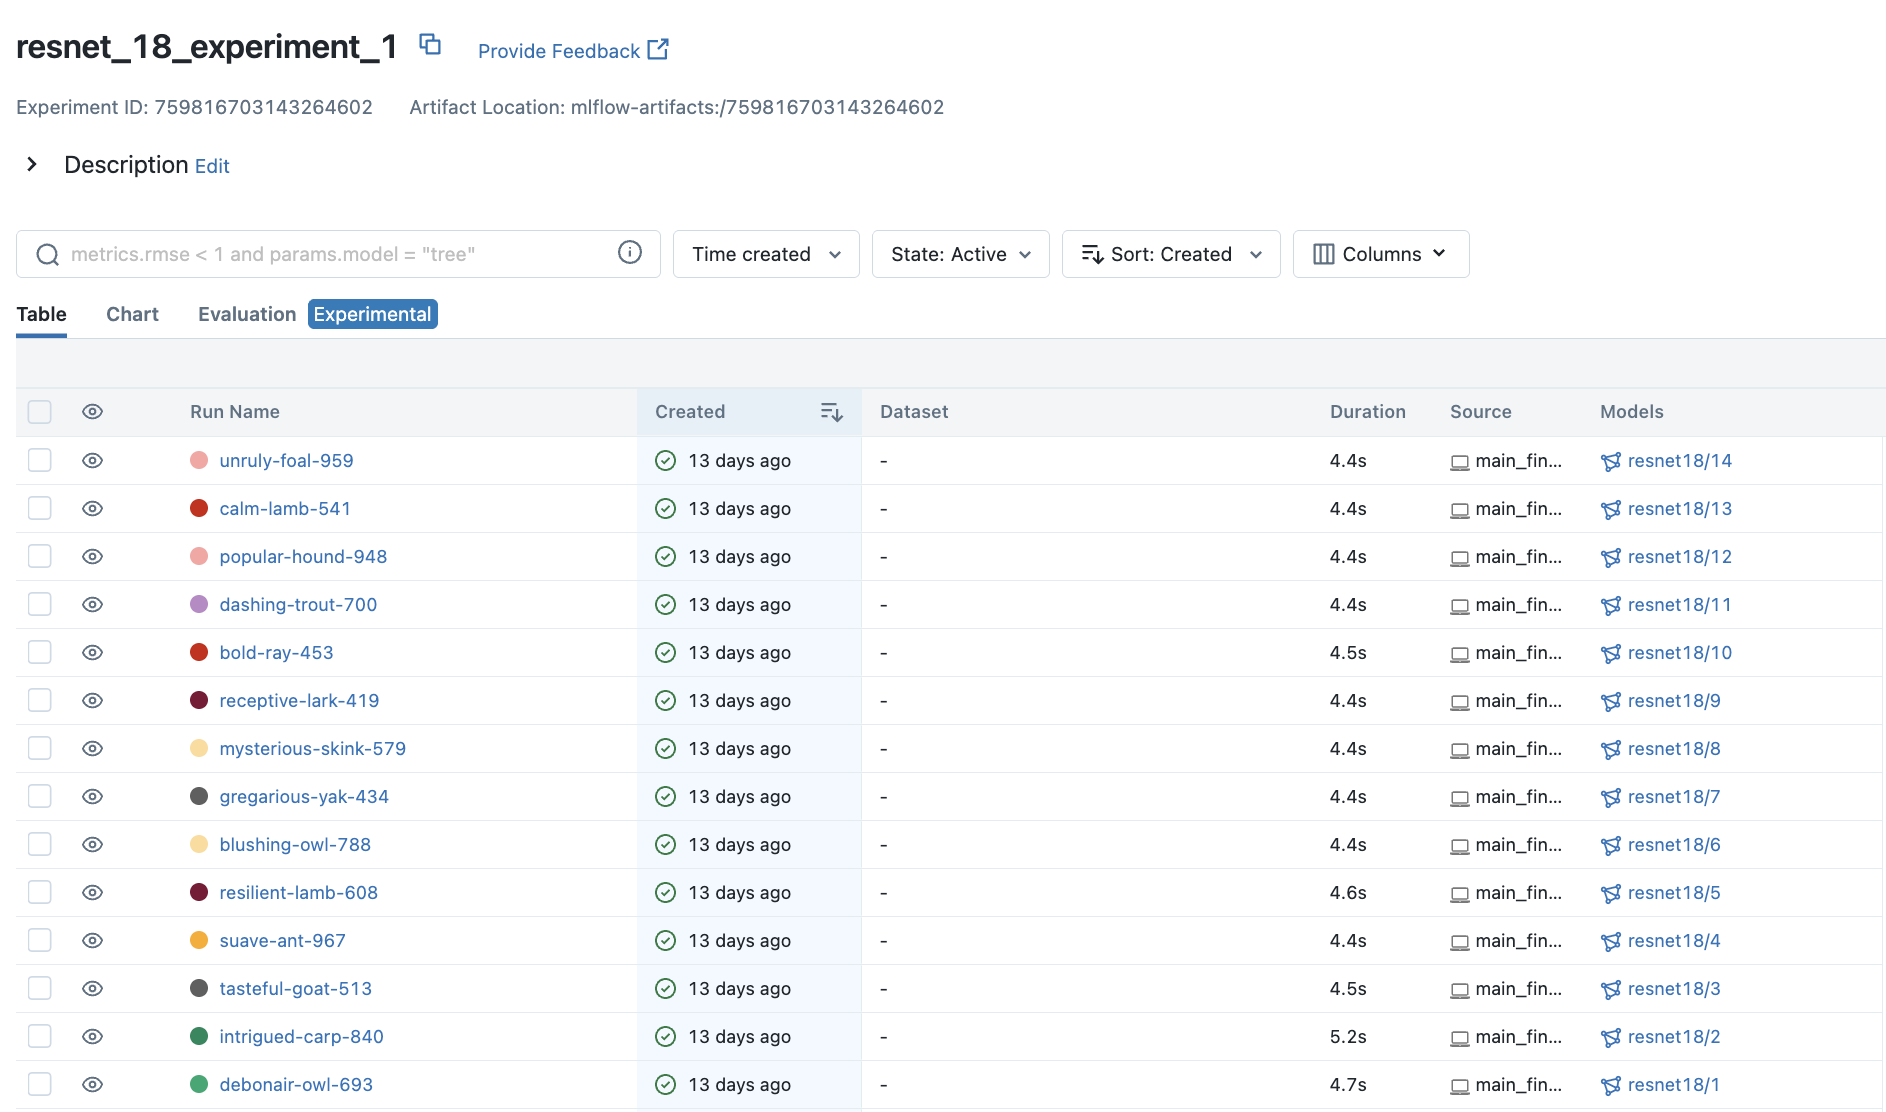

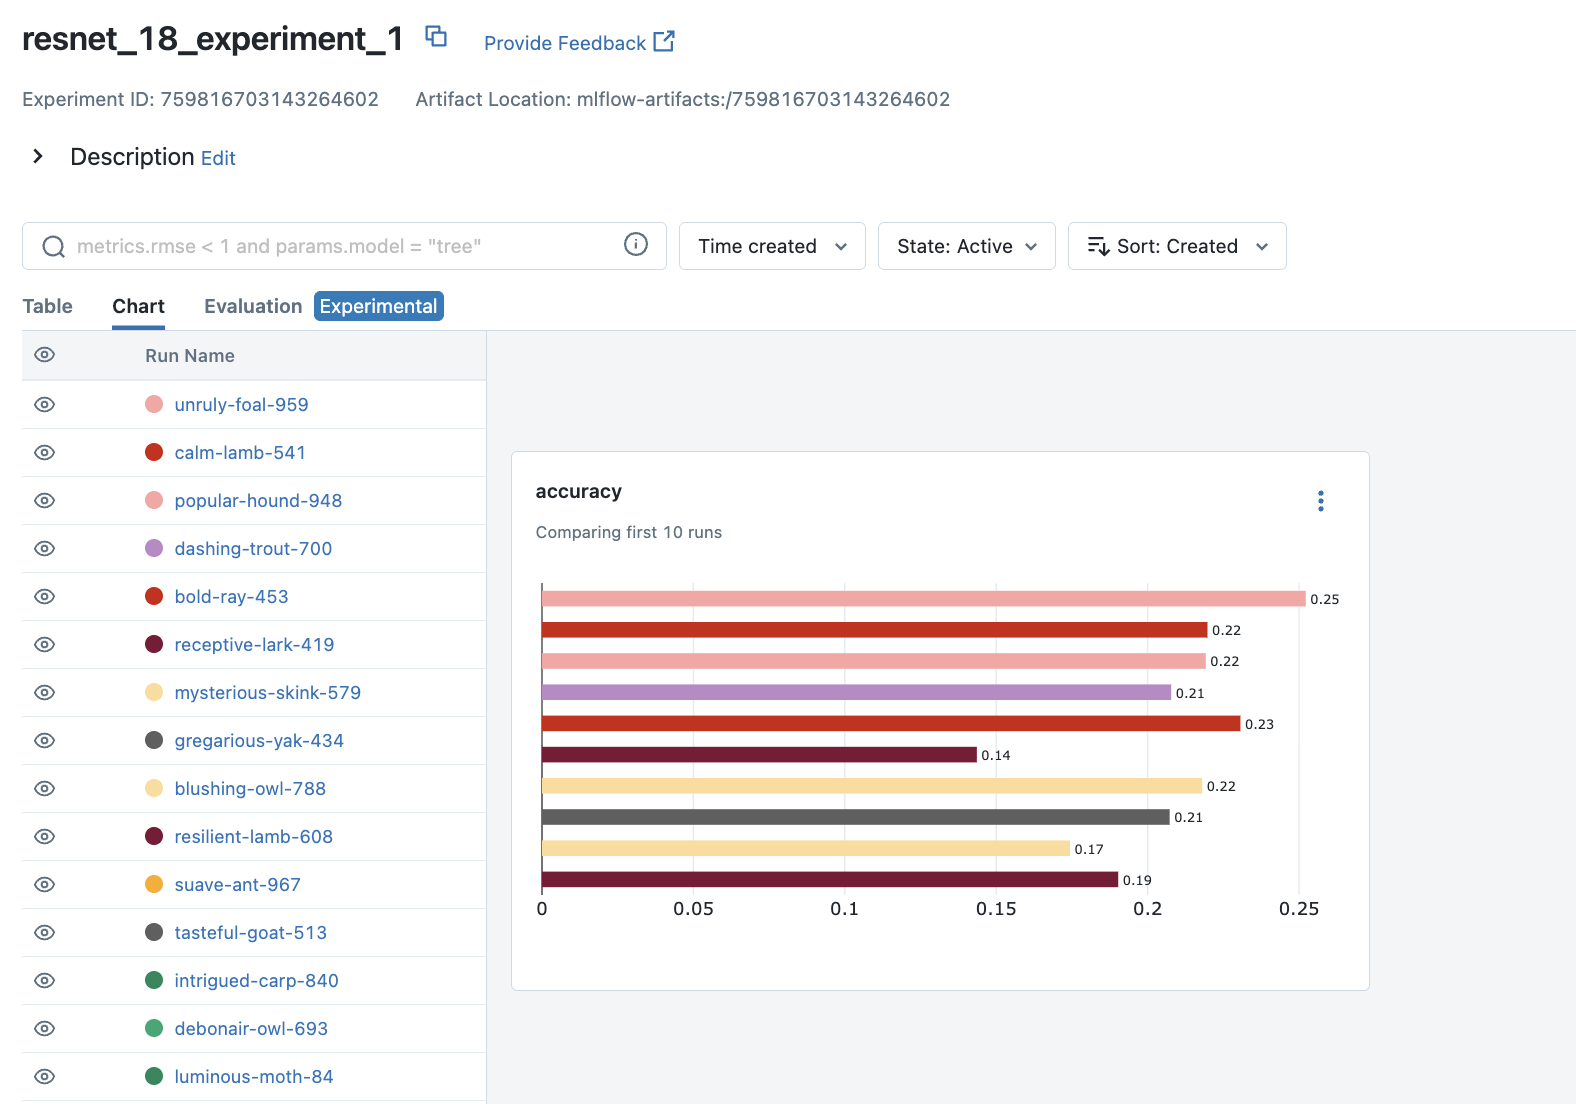